In [1]:
import random

In [2]:
random_seed = 10
random.seed(random_seed)

In [3]:
%pip install swifter
%pip install python-dotenv
%pip install bertopic
%pip install tensorflow
%pip install sentence-transformers
%pip install gensim

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
np.random.seed(10)
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

In [6]:
#shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
#df.head(5)

## Preprocessing

In [7]:
#stop words, lower case, and remove punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# preprocessing function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    # Use regular expression to replace all punctuation with a space
    text = re.sub(f'[{re.escape("".join(punctuation))}]', ' ', text)
    tokens = text.split()
    # Removed the strip() call as regex handles punctuation removal
    # tokens = [word.strip("".join(punctuation)) for word in tokens]
    tokens = [word for word in tokens if word and word not in stop_words]

    return tokens

# Add cleaned tokens to the df
df["tokens"] = df["summary"].apply(clean_text)

# Define the list of words to filter out
words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges'}

# filter out words that we think are not helpful
df['flt_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])


df['flt_tokens'] = df['flt_tokens'].apply(lambda x: ' '.join(x))

## Embedding

In [8]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
        #adding this to see the shape of the embedding
        logging.info(f"Embedding shape for input: {emb.shape}")
        return emb
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)

    if 'embedding' not in df.columns:
        df['embedding'] = None

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
# embeddings are computed and saved in df
embedding_example = df.loc[df['embedding'].notnull(), 'embedding'].iloc[0]

print(type(embedding_example))  # we want a numpy array here
print(embedding_example.shape)  # This will tell us the embedding dimensions :)

<class 'numpy.ndarray'>
(384,)


## Model Creation

In [10]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [11]:
%pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 3.1 MB/s eta 0:00:00


In [12]:
from skfuzzy.cluster import cmeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

In [13]:
# # Define Clustering Models
# soft_kmeans_model = GaussianMixture(n_components=20, random_state=42)
class FuzzyCMeansModel:
    def __init__(self, n_clusters=6, m=2, error=0.005, maxiter=1000):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.labels_ = None
        self.centers = None
        self.u = None  # Membership matrix

    def fit(self, X):
        self.centers, self.u, _, _, _, _, _ = cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter
        )
        self.labels_ = np.argmax(self.u, axis=0)
        return self

    def predict(self, X):
        return self.labels_

In [14]:
## bertopic.py ##
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)
embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()

# Initialize UMAP model with random_state for reproducibility
umap_model = UMAP(random_state=random_seed)

# Initialize Clustering Model (Fuzzy C-Means)
cluster_model = FuzzyCMeansModel(n_clusters= 6)

# Initialize BERTopic model with the UMAP model and the custom clustering model
# random_state is removed as it's not supported in this BERTopic version
bertopic_model = BERTopic(umap_model=umap_model, hdbscan_model=cluster_model)

# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

#fix for indexing, store the actual topic ids assigned by bert
df_embeddings["bertopic_topic"] = topics
df_embeddings["bertopic_prob"] = probs

# Get actual fuzzy topic probabilities from the Fuzzy C-Means model
membership_probs = cluster_model.u.T  # shape = (n_docs, n_topics)

# Turn it into a DataFrame
membership_df = pd.DataFrame(membership_probs, columns=[f"Topic_{i}" for i in range(cluster_model.n_clusters)])

# Join with df_embeddings
df_embeddings = df_embeddings.reset_index(drop=True)
df_embeddings = pd.concat([df_embeddings, membership_df], axis=1)

# Now you can access per-topic probabilities per document
df_embeddings.head()

df_embeddings["topic"] = membership_df.idxmax(axis=1).apply(lambda x: int(x.split("_")[1]))
df_embeddings["probs"] = membership_df.max(axis=1)


# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

BERTopic Topics and Top Words:
{0: [('land', 0.07697145878392946), ('communities', 0.026239839003126313), ('hcv', 0.024057791307009063), ('complainants', 0.022496112355407643), ('local', 0.02165793803706458), ('complaint', 0.020863879976157046), ('customary', 0.0192041248658682), ('allegations', 0.018327689311891354), ('process', 0.017348713767193182), ('clearing', 0.017028144388722383)], 1: [('forest', 0.0401927494644794), ('plantation', 0.036987190241737085), ('plantations', 0.031127258710846064), ('eof', 0.030986749965054686), ('mill', 0.03028786876616296), ('illegal', 0.027434206921716272), ('area', 0.027283265426724997), ('gar', 0.022731269271603616), ('investigations', 0.02135142697718735), ('supplier', 0.020768824296797456)], 2: [('earth', 0.1094287361256173), ('ha', 0.10860640754427836), ('mighty', 0.10849379764589322), ('rapid', 0.10393651427598588), ('response', 0.09632617875732023), ('concession', 0.08963716972785887), ('deforestation', 0.08496925287486813), ('indications', 

In [15]:
print(bertopic_model.get_topic_info())

   Topic  Count                                 Name  \
0      0    100  0_land_communities_hcv_complainants   
1      1     80  1_forest_plantation_plantations_eof   
2      2     74              2_earth_ha_mighty_rapid   
3      3     57        3_workers_labour_union_rights   
4      4     53       4_gar_deforestation_ran_linked   
5      5     23                 5_ffb_cpo_park_bukit   

                                      Representation  \
0  [land, communities, hcv, complainants, local, ...   
1  [forest, plantation, plantations, eof, mill, i...   
2  [earth, ha, mighty, rapid, response, concessio...   
3  [workers, labour, union, rights, employment, c...   
4  [gar, deforestation, ran, linked, chain, jaya,...   
5  [ffb, cpo, park, bukit, national, contaminated...   

                                 Representative_Docs  
0  [golden veroleum liberia provided public notif...  
1  [may june 2021 eyes forest eof published title...  
2  [mighty earth rapid response 17 indications de

## Raw Output

In [16]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic 0 Representation: ['land', 'communities', 'hcv', 'complainants', 'local', 'complaint', 'customary', 'allegations', 'process', 'clearing']
Topic 1 Representation: ['forest', 'plantation', 'plantations', 'eof', 'mill', 'illegal', 'area', 'gar', 'investigations', 'supplier']
Topic 2 Representation: ['earth', 'ha', 'mighty', 'rapid', 'response', 'concession', 'deforestation', 'indications', 'forest', 'clearance']
Topic 3 Representation: ['workers', 'labour', 'union', 'rights', 'employment', 'casual', 'daily', 'working', 'bpjs', 'termination']
Topic 4 Representation: ['gar', 'deforestation', 'ran', 'linked', 'chain', 'jaya', 'supply', 'sawit', 'plantation', 'leuser']
Topic 5 Representation: ['ffb', 'cpo', 'park', 'bukit', 'national', 'contaminated', 'products', 'eof', 'tiger', 'tesso']


In [17]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

# Visualizations

In [18]:
model_name = "LLM-BERTopic"

## Create Dataframe with Results

In [19]:
import re
import pandas as pd

def format_bertopic_sentences(model, embeddings, n_topics):
    rows = []

    for index, row in embeddings.iterrows():
        doc_num = index
        dom_topic_num = row['topic']
        dom_topic_prob = round(row['probs'], 2)
        text = row['flt_tokens']

        # Topic contribution breakdown
        topic_dist = {}
        for n in range(n_topics):
            topic_dist[f'Topic_{n}'] = row[f'Topic_{n}']

        topic_binary = {f"Topic_{i}": 0 for i in range(n_topics)}

        shared_perc = 0.0
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)

        is_outlier = False
        itr = 0

        # Use the membership probabilities from the row if available
        for i in range(n_topics):
            topic_dist[f"Topic_{i}_Perc"] = round(row[f'Topic_{i}'], 2)

            while (shared_perc < 0.5):
                # Get Topic Number and Topic Percentage
                topic_num, topic_perc = sorted_doc[itr]
                topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
                shared_perc += topic_perc
                topic_binary[f"Topic_{topic_num}"] = 1  # Multi-Label Binary Classifcation
                itr += 1

            # Check if Outlier
            if (itr) > (number_of_topics/2):
                is_outlier = True

        # Keywords
        keywords = ", ".join([word for word, _ in model.get_topic(row['bertopic_topic'])])


        # Construct the document row
        row_data = {
            'Document_Num': doc_num,
            'Dominant_Topic': dom_topic_num,
            'Topic_%_Contrib': dom_topic_prob,
            'Topic_Keywords': keywords,
            'Text': text,
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row_data.update(topic_dist)
        row_data.update(topic_binary)
        rows.append(row_data)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [20]:
# Assuming membership_df is available from the previous cell
# Get the number of topics from the membership_df columns (excluding original columns)
number_of_topics = len(membership_df.columns)


dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)
dominant_topic_df

Document_Num  Dominant_Topic  Topic_%_Contrib  \
0               0               4             0.96   
1               1               4             0.99   
2               2               0             0.80   
3               3               2             0.81   
4               4               0             0.45   
..            ...             ...              ...   
382           382               0             0.56   
383           383               2             0.98   
384           384               1             0.52   
385           385               1             0.47   
386           386               1             0.43   

                                        Topic_Keywords  \
0    workers, labour, union, rights, employment, ca...   
1    workers, labour, union, rights, employment, ca...   
2    land, communities, hcv, complainants, local, c...   
3    forest, plantation, plantations, eof, mill, il...   
4    land, communities, hcv, complainants, local, c...   
..                                                 ...   
382  land, communities, hcv, complainants, local, c...   
383  forest, plantation, plantations, eof, mill, il...   
384  earth, ha, mighty, rapid, response, concession...   
385  earth, ha, mighty, rapid, response, concession...   
386  earth, ha, mighty, rapid, response, concession...   

                                                  Text  Is_Outlier  \
0    transferred different department purportedly p...       False   
1    unjustifiably dismissed workers deceiving resi...       False   
2    1 owns operates plantations conflicted contest...       False   
3    corporate social responsibility csr program co...       False   
4    breached obligations ignoring high conservatio...       False   
..                                                 ...         ...   
382  rights violations land conflict sandabi indah ...       False   
383  rimba harapan saksti rhs sarana titian permata...       False   
384  construction canal prepare deep forested peatl...       False   
385  clearance potential high carbon stock hcs fore...       False   
386  clearance potential high carbon stock hcs fore...       False   

     Dom_Topics_Num  Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  \
0                 1        0        0        0        0        1        0   
1                 1        0        0        0        0        1        0   
2                 1        1        0        0        0        0        0   
3                 1        0        0        1        0        0        0   
4                 2        1        0        1        0        0        0   
..              ...      ...      ...      ...      ...      ...      ...   
382               1        1        0        0        0        0        0   
383               1        0        0        1        0        0        0   
384               1        0        1        0        0        0        0   
385               2        0        1        0        1        0        0   
386               2        0        1        0        1        0        0   

     Topic_0_Perc  Topic_1_Perc  Topic_2_Perc  Topic_3_Perc  Topic_4_Perc  \
0            0.02          0.00          0.01          0.00          0.96   
1            0.00          0.00          0.00          0.00          0.99   
2            0.80          0.01          0.11          0.03          0.02   
3            0.06          0.01          0.81          0.04          0.01   
4            0.45          0.02          0.41          0.05          0.03   
..            ...           ...           ...           ...           ...   
382          0.56          0.02          0.08          0.04          0.26   
383          0.01          0.00          0.98          0.01          0.00   
384          0.04          0.52          0.08          0.32          0.02   
385          0.06          0.47          0.09          0.31          0.03   
386          0.07          0.43          0.11 

### Saving to CSV

In [21]:
# Convert to CSV and save
dominant_topic_df.to_csv("BERTopic_results.csv",index = False)
from google.colab import files
# files.download("BERTopic_results.csv")

## Data Exploration

In [22]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3].sort_values(by='Topic_%_Contrib', ascending=False)

Document_Num  Dominant_Topic  Topic_%_Contrib  \
337           337               3             1.00   
212           212               3             1.00   
338           338               3             0.99   
232           232               3             0.98   
213           213               3             0.98   
187           187               3             0.97   
216           216               3             0.96   
285           285               3             0.95   
209           209               3             0.94   
174           174               3             0.93   
286           286               3             0.93   
215           215               3             0.92   
334           334               3             0.90   
270           270               3             0.89   
368           368               3             0.86   
350           350               3             0.84   
372           372               3             0.83   
245           245               3             0.82   
330           330               3             0.81   
345           345               3             0.79   
342           342               3             0.79   
363           363               3             0.78   
356           356               3             0.76   
365           365               3             0.75   
360           360               3             0.74   
352           352               3             0.74   
349           349               3             0.74   
358           358               3             0.73   
327           327               3             0.69   
208           208               3             0.69   
279           279               3             0.69   
329           329               3             0.67   
214           214               3             0.67   
284           284               3             0.66   
306           306               3             0.63   
200           200               3             0.62   
182           182               3             0.61   
192           192               3             0.58   
276           276               3             0.57   
231           231               3             0.57   
176           176               3             0.57   
324           324               3             0.56   
175           175               3             0.56   
201           201               3             0.56   
233           233               3             0.53   
252           252               3             0.52   
253           253               3             0.50   
191           191               3             0.48   
321           321               3             0.45   
278           278               3             0.45   
188           188               3             0.42   
190           190               3             0.42   
256           256               3             0.41   

                                        Topic_Keywords  \
337  gar, deforestation, ran, linked, chain, jaya, ...   
212  gar, deforestation, ran, linked, chain, jaya, ...   
338  gar, deforestation, ran, linked, chain, jaya, ...   
232  gar, deforestation, ran, linked, chain, jaya, ...   
213  gar, deforestation, ran, linked, chain, jaya, ...   
187  gar, deforestation, ran, linked, chain, jaya, ...   
216  gar, deforestation, ran, linked, chain, jaya, ...   
285  gar, deforestation, ran, linked, chain, jaya, ...   
209  gar, deforestation, ran, linked, chain, jaya, ...   
174  gar, deforestation, ran, linked, chain, jaya, ...   
286  gar, deforestation, ran, linked, chain, jaya, ...   
215  gar, deforestation, ran, linked, chain, jaya, ...   
334  gar, deforestation, ran, linked, chain, jaya, ...   
270  gar, deforestation, ran, linked, chain, jaya, ...   
368  gar, deforestation, ran, linked, chain, jaya, ...   
350  gar, deforestation, ran, linked, chain, jaya, ...   
372  gar, deforestation, ran, linked, chain, jaya, ...   
245  gar, deforestation, ran, linked, chain,

## Wordcloud

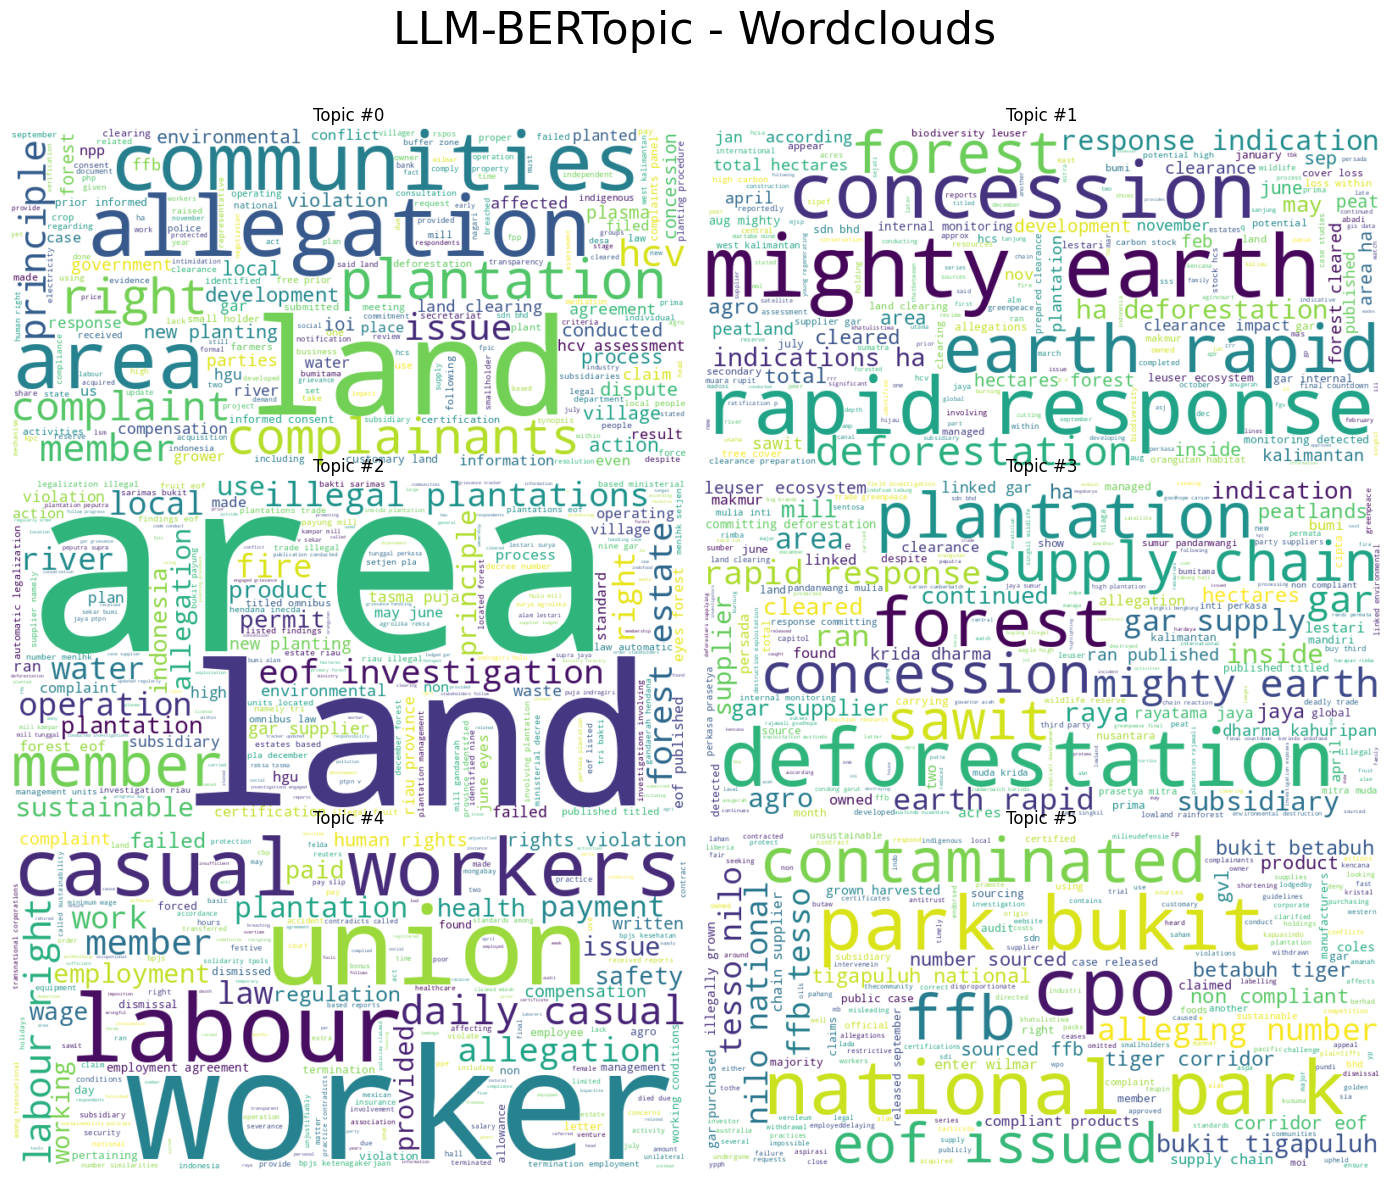

In [23]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordclouds', n_topics=6)

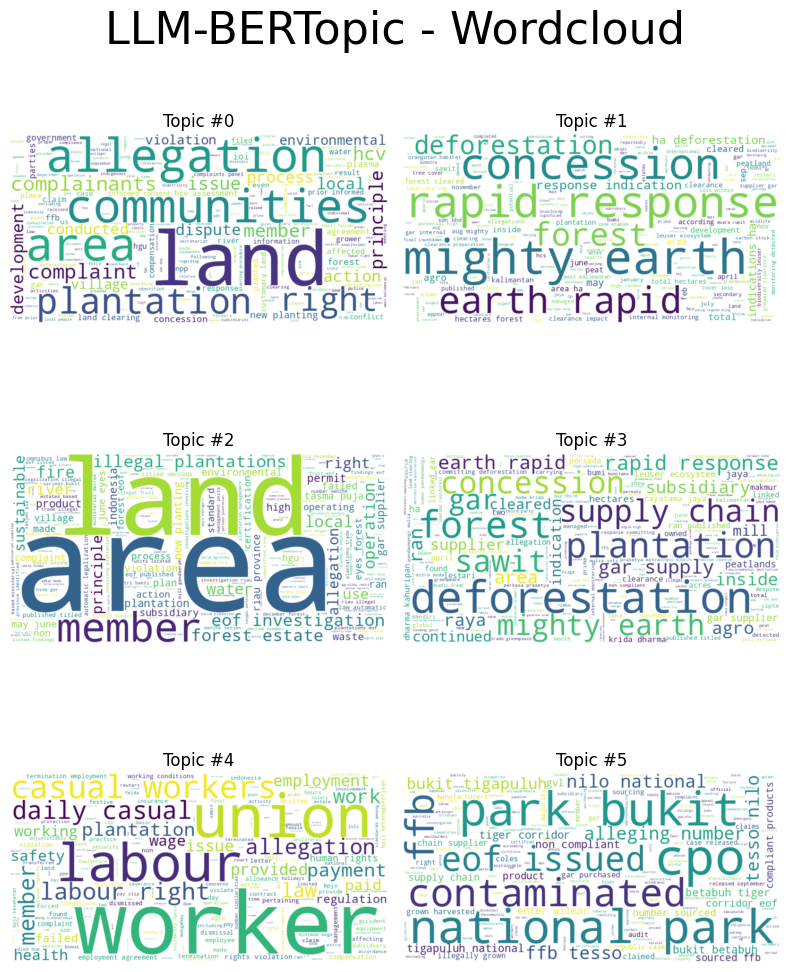

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(8, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32, y=0.9)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordcloud', n_topics=6)

## Dominant Topic Frequency

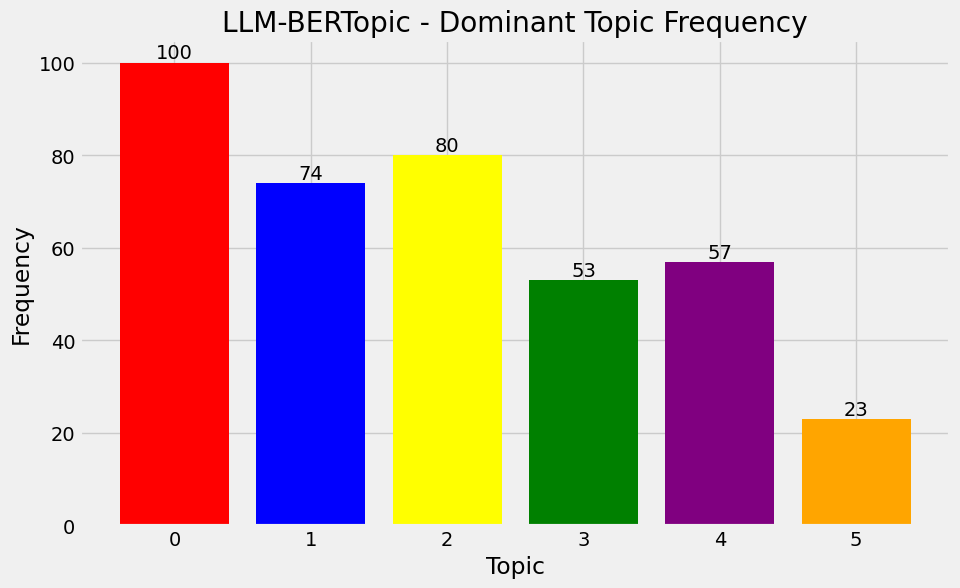

In [25]:
plt.style.use('fivethirtyeight')

# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['Document_Num']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Topic Distribution per Doc

In [26]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['Document_Num'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

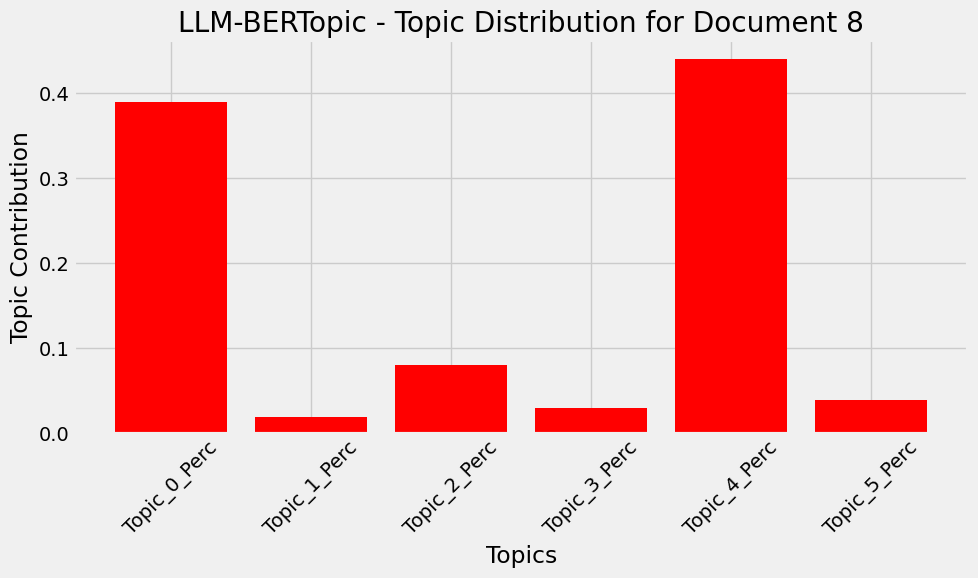

In [27]:
doc_number = 8    # Change This
topic_dist_doc(dominant_topic_df, number_of_topics, doc_num=doc_number)

## Overall Dominant Topic % Share

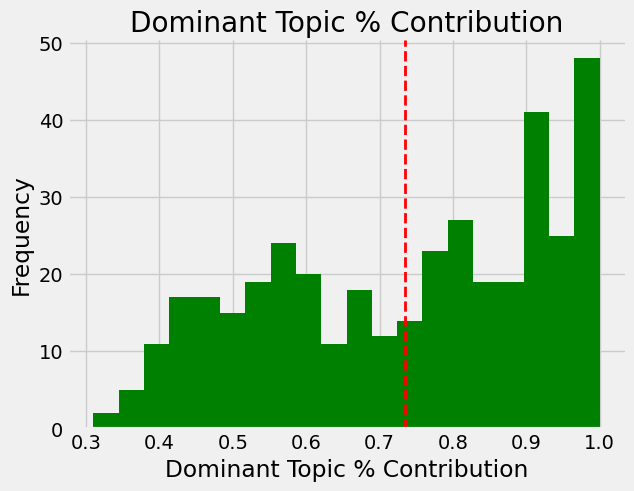

In [28]:
# Ensure dominant_topic_df is available
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Plot a histogram of the 'Topic_%_Contrib' column from dominant_topic_df
    dominant_topic_df['Topic_%_Contrib'].plot(kind='hist', bins=20, title='Dominant Topic % Contribution', color="green")
    plt.gca().spines[['top', 'right',]].set_visible(False)

    # Add Mean line
    mean_value = dominant_topic_df['Topic_%_Contrib'].mean()
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

    plt.xlabel('Dominant Topic % Contribution')
    plt.ylabel('Frequency')
    plt.show() # Add plt.show() to display the plot

# Scoring Methods

## Topic Coherence Score

In [29]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df_embeddings['flt_tokens']]
dictionary = Dictionary(texts)

topic_words = [[word for word, _ in bertopic_model.get_topic(i)] for i in range(len(bertopic_model.get_topics())) if i != -1]

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Topic Coherence:", coherence_score)


Topic Coherence: 0.6647878673914204


## Topic Diversity

In [30]:
topic_words = [bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics())) if i != -1]
top_words = [word for topic in topic_words for word, _ in topic[:10]]
unique_words = len(set(top_words))
total_words = len(top_words)
diversity = unique_words / total_words
print("Topic Diversity:", diversity)

Topic Diversity: 0.9166666666666666


## Silhouette Score

In [31]:
from sklearn.metrics import silhouette_score

# Use embeddings and predicted topics (excluding -1)
mask = df_embeddings['topic'] != -1
score = silhouette_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Silhouette Score:", score)

Silhouette Score: 0.042725343


## Davies-Bouldin Index

In [32]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Davies-Bouldin Index:", score)

Davies-Bouldin Index: 3.9848231768712665


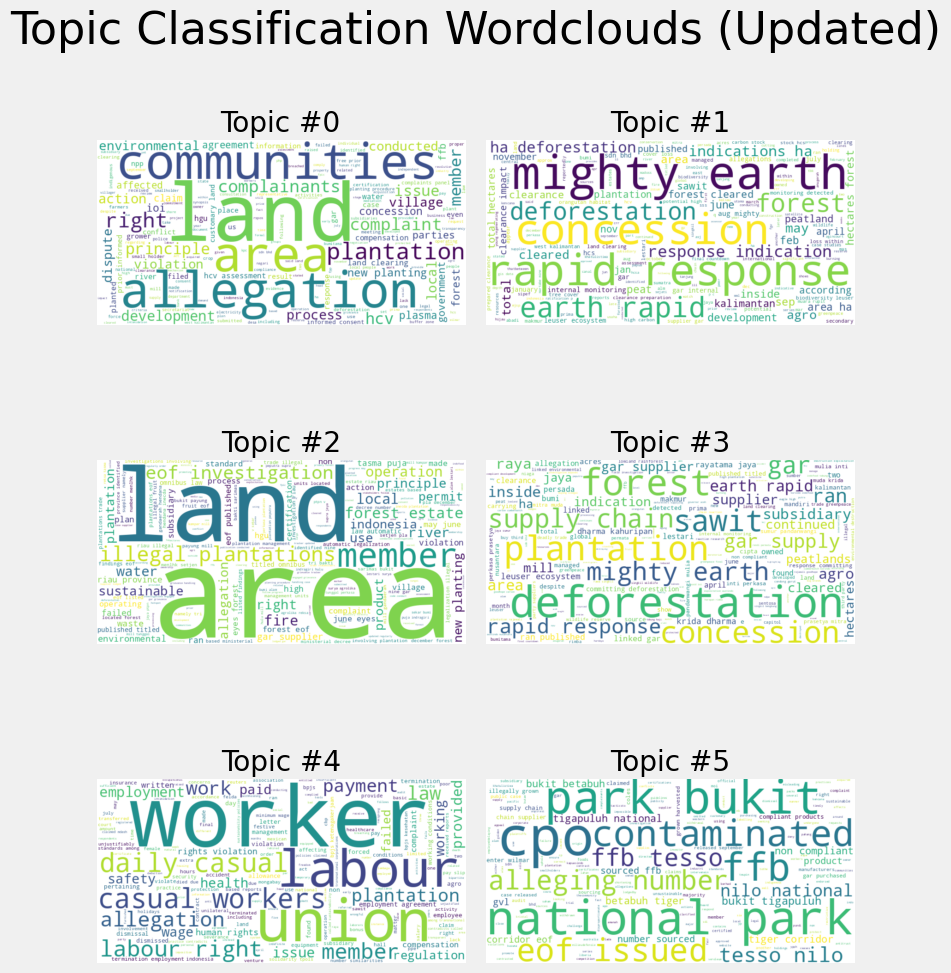

In [33]:
dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)
display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds (Updated)', n_topics=number_of_topics)

In [34]:
bertopic_model.visualize_hierarchy()

In [35]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 5/5 [00:00<00:00, 228.27it/s]


In [36]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)

#Undersampling

In [37]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3].sort_values(by='Topic_%_Contrib', ascending=False)

Document_Num  Dominant_Topic  Topic_%_Contrib  \
337           337               3             1.00   
212           212               3             1.00   
338           338               3             0.99   
232           232               3             0.98   
213           213               3             0.98   
187           187               3             0.97   
216           216               3             0.96   
285           285               3             0.95   
209           209               3             0.94   
174           174               3             0.93   
286           286               3             0.93   
215           215               3             0.92   
334           334               3             0.90   
270           270               3             0.89   
368           368               3             0.86   
350           350               3             0.84   
372           372               3             0.83   
245           245               3             0.82   
330           330               3             0.81   
345           345               3             0.79   
342           342               3             0.79   
363           363               3             0.78   
356           356               3             0.76   
365           365               3             0.75   
360           360               3             0.74   
352           352               3             0.74   
349           349               3             0.74   
358           358               3             0.73   
327           327               3             0.69   
208           208               3             0.69   
279           279               3             0.69   
329           329               3             0.67   
214           214               3             0.67   
284           284               3             0.66   
306           306               3             0.63   
200           200               3             0.62   
182           182               3             0.61   
192           192               3             0.58   
276           276               3             0.57   
231           231               3             0.57   
176           176               3             0.57   
324           324               3             0.56   
175           175               3             0.56   
201           201               3             0.56   
233           233               3             0.53   
252           252               3             0.52   
253           253               3             0.50   
191           191               3             0.48   
321           321               3             0.45   
278           278               3             0.45   
188           188               3             0.42   
190           190               3             0.42   
256           256               3             0.41   

                                        Topic_Keywords  \
337  gar, deforestation, ran, linked, chain, jaya, ...   
212  gar, deforestation, ran, linked, chain, jaya, ...   
338  gar, deforestation, ran, linked, chain, jaya, ...   
232  gar, deforestation, ran, linked, chain, jaya, ...   
213  gar, deforestation, ran, linked, chain, jaya, ...   
187  gar, deforestation, ran, linked, chain, jaya, ...   
216  gar, deforestation, ran, linked, chain, jaya, ...   
285  gar, deforestation, ran, linked, chain, jaya, ...   
209  gar, deforestation, ran, linked, chain, jaya, ...   
174  gar, deforestation, ran, linked, chain, jaya, ...   
286  gar, deforestation, ran, linked, chain, jaya, ...   
215  gar, deforestation, ran, linked, chain, jaya, ...   
334  gar, deforestation, ran, linked, chain, jaya, ...   
270  gar, deforestation, ran, linked, chain, jaya, ...   
368  gar, deforestation, ran, linked, chain, jaya, ...   
350  gar, deforestation, ran, linked, chain, jaya, ...   
372  gar, deforestation, ran, linked, chain, jaya, ...   
245  gar, deforestation, ran, linked, chain,

In [38]:
top_40_per_topic = (
    dominant_topic_df
    .sort_values(by='Topic_%_Contrib', ascending=False)
    .groupby('Dominant_Topic', group_keys=False)
    .head(40)
)
top_40_per_topic

Document_Num  Dominant_Topic  Topic_%_Contrib  \
337           337               3             1.00   
194           194               5             1.00   
9               9               4             1.00   
205           205               4             1.00   
212           212               3             1.00   
..            ...             ...              ...   
192           192               3             0.58   
176           176               3             0.57   
231           231               3             0.57   
81             81               5             0.56   
106           106               5             0.39   

                                        Topic_Keywords  \
337  gar, deforestation, ran, linked, chain, jaya, ...   
194  ffb, cpo, park, bukit, national, contaminated,...   
9    workers, labour, union, rights, employment, ca...   
205  workers, labour, union, rights, employment, ca...   
212  gar, deforestation, ran, linked, chain, jaya, ...   
..                                                 ...   
192  gar, deforestation, ran, linked, chain, jaya, ...   
176  gar, deforestation, ran, linked, chain, jaya, ...   
231  gar, deforestation, ran, linked, chain, jaya, ...   
81   ffb, cpo, park, bukit, national, contaminated,...   
106  ffb, cpo, park, bukit, national, contaminated,...   

                                                  Text  Is_Outlier  \
337  dec 2022 eia published worst deforesters 2022 ...       False   
194  eof claims gar purchased ffb illegally grown h...       False   
9    allegations raised pertaining variety workers ...       False   
205  sawit mas sejahtera sms accused complying labo...       False   
212  mighty earth rapid response 1 4 carried defore...       False   
..                                                 ...         ...   
192  anugerah energitama ae concerning orangutans t...       False   
176  ran indo sawit perkasa isp caught destroying l...       False   
231  deadly trade greenpeace said ioi continued buy...       False   
81   golden veroleum liberia majority owned subsidi...       False   
106  allegations 1 coles labelling packs product co...       False   

     Dom_Topics_Num  Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  \
337               1        0        0        0        1        0        0   
194               1        0        0        0        0        0        1   
9                 1        0        0        0        0        1        0   
205               1        0        0        0        0        1        0   
212               1        0        0        0        1        0        0   
..              ...      ...      ...      ...      ...      ...      ...   
192               1        0        0        0        1        0        0   
176               1        0        0        0        1        0        0   
231               1        0        0        0        1        0        0   
81                1        0        0        0        0        0        1   
106               2        0        0        1        0        0        1   

     Topic_0_Perc  Topic_1_Perc  Topic_2_Perc  Topic_3_Perc  Topic_4_Perc  \
337          0.00          0.00          0.00          1.00          0.00   
194          0.00          0.00          0.00          0.00          0.00   
9            0.00          0.00          0.00          0.00          1.00   
205          0.00          0.00          0.00          0.00          1.00   
212          0.00          0.00          0.00          1.00          0.00   
..            ...           ...           ...           ...           ...   
192          0.02          0.34          0.04          0.58          0.01   
176          0.06          0.09          0.23          0.57          0.02   
231          0.04          0.08          0.24          0.57          0.01   
81           0.06          0.03          0.26          0.07          0.02   
106          0.11          0.03          0.39 

In [39]:
top_40_per_topic[top_40_per_topic['Dominant_Topic'] == 5].sort_values(by='Topic_%_Contrib', ascending=False)

Document_Num  Dominant_Topic  Topic_%_Contrib  \
194           194               5             1.00   
193           193               5             0.99   
227           227               5             0.99   
195           195               5             0.98   
196           196               5             0.98   
31             31               5             0.98   
7               7               5             0.98   
226           226               5             0.98   
234           234               5             0.98   
68             68               5             0.92   
347           347               5             0.87   
355           355               5             0.83   
370           370               5             0.82   
102           102               5             0.82   
357           357               5             0.82   
346           346               5             0.81   
371           371               5             0.80   
375           375               5             0.69   
373           373               5             0.68   
374           374               5             0.66   
294           294               5             0.60   
81             81               5             0.56   
106           106               5             0.39   

                                        Topic_Keywords  \
194  ffb, cpo, park, bukit, national, contaminated,...   
193  ffb, cpo, park, bukit, national, contaminated,...   
227  ffb, cpo, park, bukit, national, contaminated,...   
195  ffb, cpo, park, bukit, national, contaminated,...   
196  ffb, cpo, park, bukit, national, contaminated,...   
31   ffb, cpo, park, bukit, national, contaminated,...   
7    ffb, cpo, park, bukit, national, contaminated,...   
226  ffb, cpo, park, bukit, national, contaminated,...   
234  ffb, cpo, park, bukit, national, contaminated,...   
68   ffb, cpo, park, bukit, national, contaminated,...   
347  ffb, cpo, park, bukit, national, contaminated,...   
355  ffb, cpo, park, bukit, national, contaminated,...   
370  ffb, cpo, park, bukit, national, contaminated,...   
102  ffb, cpo, park, bukit, national, contaminated,...   
357  ffb, cpo, park, bukit, national, contaminated,...   
346  ffb, cpo, park, bukit, national, contaminated,...   
371  ffb, cpo, park, bukit, national, contaminated,...   
375  ffb, cpo, park, bukit, national, contaminated,...   
373  ffb, cpo, park, bukit, national, contaminated,...   
374  ffb, cpo, park, bukit, national, contaminated,...   
294  ffb, cpo, park, bukit, national, contaminated,...   
81   ffb, cpo, park, bukit, national, contaminated,...   
106  ffb, cpo, park, bukit, national, contaminated,...   

                                                  Text  Is_Outlier  \
194  eof claims gar purchased ffb illegally grown h...       False   
193  eof claimed gar purchased ffb illegally grown ...       False   
227  eof claimed gar purchased ffb illegally grown ...       False   
195  eof issued alleging number sourced ffb tesso n...       False   
196  eof issued alleging number sourced ffb tesso n...       False   
31   supply cpo ffb unsustainable sources supplies ...       False   
7    acquired ffb using restrictive competition pra...       False   
226  eof claimed gar purchased ffb illegally grown ...       False   
234  eof issued alleging number sourced ffb tesso n...       False   
68   1 sourcing ffb unsustainable origin 2 failure ...       False   
347  sourcing non compliant ffb aspirasi kristal sd...       False   
355  non compliant products indo alam enter wilmar’...       False   
370  non compliant products alas kusuma enter wilma...       False   
102  western pacific oils claimed purchasing mb sho...       False   
357  non compliant products amanah saham pahang ber...       False   
346  non compliant products yp plantation holdings ...       False   
371  non compliant products enter wilmar supply cha...       False   
375                public case released september 2018 

In [40]:
top_40_per_topic.to_csv('top_40_per_topic.csv', index=False)

from google.colab import files
files.download('top_40_per_topic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# over sampling

In [55]:
import pandas as pd
import numpy as np

df = dominant_topic_df.copy()

# ✅ Use correct columns
topic_col = 'Dominant_Topic'        # Topic label
prob_col = 'Topic_%_Contrib'        # Probability/confidence

confidence_threshold = 0.4
top_n = 40
medium_n = 20
output_csv = "balanced_topics.csv"

filtered_df = df[df[prob_col] >= confidence_threshold]

balanced_dfs = []

for topic in filtered_df[topic_col].unique():
    topic_df = filtered_df[filtered_df[topic_col] == topic]

    strong = topic_df.sort_values(prob_col, ascending=False).head(top_n)
    medium_pool = topic_df[(topic_df[prob_col] >= confidence_threshold) &
                           (topic_df[prob_col] < strong[prob_col].min())]
    medium = medium_pool.sample(min(len(medium_pool), medium_n), random_state=42)

    balanced_dfs.append(pd.concat([strong, medium]))

balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df.to_csv(output_csv, index=False)

print(f"Balanced dataset saved to {output_csv} with {len(balanced_df)} rows.")
print("\nCount of each topic in balanced_df:")
print(balanced_df[topic_col].value_counts())


Balanced dataset saved to balanced_topics.csv with 311 rows.

Count of each topic in balanced_df:
Dominant_Topic
0    60
1    60
2    60
4    57
3    52
5    22
Name: count, dtype: int64


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

# ✅ X = your features (can be BERT embeddings or TF-IDF)
# For example, if you have 'embeddings' as a numpy array:
X = np.array(df_embeddings['embedding'].tolist())  # change to your actual embeddings variable

# ✅ Hard labels (Dominant topic)
y_hard = dominant_topic_df['Dominant_Topic'].values  # integer topic label

# ✅ Soft labels (topic probabilities)
topic_cols = [col for col in dominant_topic_df.columns if col.startswith('Topic_') and col.endswith('_Perc')]
y_soft = dominant_topic_df[topic_cols].values  # matrix of topic probabilities

# ---- Split data ----
X_train, X_test, y_hard_train, y_hard_test, y_soft_train, y_soft_test = train_test_split(
    X, y_hard, y_soft, test_size=0.2, random_state=42, stratify=y_hard)

# ---- HARD LABEL MODEL ----
clf_hard = LogisticRegression(max_iter=200)
clf_hard.fit(X_train, y_hard_train)

y_hard_pred = clf_hard.predict(X_test)
hard_acc = accuracy_score(y_hard_test, y_hard_pred)

# ---- SOFT LABEL MODEL ----
clf_soft = LogisticRegression(max_iter=200, multi_class='multinomial')
# Train on hard labels as the model expects 1D array
clf_soft.fit(X_train, y_hard_train)

y_soft_pred = clf_soft.predict_proba(X_test)  # predicted distributions
# Evaluate soft-label model against true hard labels
soft_loss = log_loss(y_hard_test, y_soft_pred)

# ---- Results ----
print(f"🔹 Hard-label model accuracy: {hard_acc:.3f}")
print(f"🔹 Soft-label model log-loss: {soft_loss:.3f} (lower is better)")

🔹 Hard-label model accuracy: 0.872
🔹 Soft-label model log-loss: 0.695 (lower is better)


In [87]:
import pandas as pd

# --- Step 1: Define the file paths for your train, validation, and test CSV files ---
train_csv_path = "/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TRAIN.csv"
val_csv_path = "/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_VAL.csv"
test_csv_path = "/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv"

# --- Step 2: Load the CSV files into Pandas DataFrames ---
try:
    train_df = pd.read_csv(train_csv_path)
    val_df = pd.read_csv(val_csv_path)
    test_df = pd.read_csv(test_csv_path)

    print("CSV files loaded successfully!")
    print(f"Train DataFrame shape: {train_df.shape}")
    print(f"Validation DataFrame shape: {val_df.shape}")
    print(f"Test DataFrame shape: {test_df.shape}")

    # Display the first few rows of each DataFrame to verify
    print("\nTrain Data Head:")
    print(train_df.head())
    print("\nValidation Data Head:")
    print(val_df.head())
    print("\nTest Data Head:")
    print(test_df.head())

except FileNotFoundError:
    print("Error: One or more CSV files not found. Please double-check your file paths.")
except Exception as e:
    print(f"An error occurred while loading CSV files: {e}")
    print("Please ensure your CSV files are well-formatted and readable.")

# --- Step 3: Merge topic probabilities from dominant_topic_df ---
# Ensure dominant_topic_df is available from previous steps
if 'dominant_topic_df' in locals():
    # Select only the 'Document_Num' and the probability columns from dominant_topic_df
    probability_cols = [col for col in dominant_topic_df.columns if col.startswith('Topic_') and col.endswith('_Perc')]
    cols_to_merge = ['Document_Num'] + probability_cols
    dominant_topic_probs = dominant_topic_df[cols_to_merge].copy()

    # Merge with train_df and val_df using 'Document_Num'
    train_df = pd.merge(train_df, dominant_topic_probs, on='Document_Num', how='left')
    val_df = pd.merge(val_df, dominant_topic_probs, on='Document_Num', how='left')
    # No need to merge with test_df if you only need probabilities for train/val

    print("\nMerged topic probabilities:")
    print("Train DataFrame with probabilities Head:")
    print(train_df.head())
    print("\nValidation DataFrame with probabilities Head:")
    print(val_df.head())

else:
    print("\nWarning: 'dominant_topic_df' not found. Skipping merging of topic probabilities.")

# --- Step 4: Prepare data for your BERT model ---
TEXT_COLUMN = 'Text'
LABEL_COLUMN = 'Dominant_Topic' # Keep hard labels for now

# Extract text and hard labels as lists
X_train = train_df[TEXT_COLUMN].tolist()
y_train_hard = train_df[LABEL_COLUMN].tolist()

X_val = val_df[TEXT_COLUMN].tolist()
y_val_hard = val_df[LABEL_COLUMN].tolist()

X_test = test_df[TEXT_COLUMN].tolist()
y_test_hard = test_df[LABEL_COLUMN].tolist()

# Extract soft labels (probabilities)
y_train_soft = train_df[probability_cols].values
y_val_soft = val_df[probability_cols].values
# y_test_soft would be similarly extracted from test_df if needed

print(f"\nPrepared {len(X_train)} training samples with hard and soft labels.")
print(f"Prepared {len(X_val)} validation samples with hard and soft labels.")
print(f"Prepared {len(X_test)} test samples with hard labels.")

# Now, X_train, y_train_hard, y_train_soft, X_val, y_val_hard, y_val_soft, X_test, and y_test_hard
# can be used as input for your BERT model finetuning and evaluation.

CSV files loaded successfully!
Train DataFrame shape: (231, 2)
Validation DataFrame shape: (78, 2)
Test DataFrame shape: (170, 9)

Train Data Head:
                                                Text  Dominant_Topic
0  following initial diagnosis process allegation...               0
1  nagari kapa long demanded clarity extent php 1...               0
2  forest clearance involvement land dispute indo...               2
3  amongst allegations fact identified follows fo...               0
4  greenpeace 3rd alert bulletin felda global ven...               4

Validation Data Head:
                                                Text  Dominant_Topic
0  deforestation aa sawit linked supplier jernih ...               3
1                public case released september 2018               5
2  early november greenpeace published burning ho...               3
3  may june 2021 eyes forest eof published titled...               2
4  mekar bumi andalas currently contact member co...               0



KeyError: 'Document_Num'

In [64]:
train_df

Text  Dominant_Topic
0    following initial diagnosis process allegation...               0
1    nagari kapa long demanded clarity extent php 1...               0
2    forest clearance involvement land dispute indo...               2
3    amongst allegations fact identified follows fo...               0
4    greenpeace 3rd alert bulletin felda global ven...               4
..                                                 ...             ...
226  synopsis sime darby received complaint operati...               0
227  mighty earth rapid response 22 indications 136...               1
228  mar rapid response 25 jan 11 feb 24 total 221 ...               1
229  allegation commenced planting activities prope...               0
230  decrease number workers union due actions prev...               4

[231 rows x 2 columns]

In [68]:
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure dominant_topic_df is available and contains all necessary columns
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cells to create it first.")
else:
    # Split dominant_topic_df into train, validation, and test sets
    # We will stratify by 'Dominant_Topic' to maintain topic distribution
    train_df, temp_df = train_test_split(
        dominant_topic_df,
        test_size=0.3, # 30% for temp (validation + test)
        random_state=42,
        stratify=dominant_topic_df['Dominant_Topic']
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5, # Split temp equally into validation and test (15% each)
        random_state=42,
        stratify=temp_df['Dominant_Topic']
    )

    print("Data split successfully into train, validation, and test sets.")
    print(f"Train DataFrame shape: {train_df.shape}")
    print(f"Validation DataFrame shape: {val_df.shape}")
    print(f"Test DataFrame shape: {test_df.shape}")

    # --- Prepare data for your BERT model ---
    TEXT_COLUMN = 'Text'
    LABEL_COLUMN_HARD = 'Dominant_Topic'
    # Identify probability columns
    probability_cols = [col for col in dominant_topic_df.columns if col.startswith('Topic_') and col.endswith('_Perc')]

    # Extract text and hard labels as lists
    X_train = train_df[TEXT_COLUMN].tolist()
    y_train_hard = train_df[LABEL_COLUMN_HARD].tolist()

    X_val = val_df[TEXT_COLUMN].tolist()
    y_val_hard = val_df[LABEL_COLUMN_HARD].tolist()

    X_test = test_df[TEXT_COLUMN].tolist()
    y_test_hard = test_df[LABEL_COLUMN_HARD].tolist()

    # Extract soft labels (probabilities)
    y_train_soft = train_df[probability_cols].values
    y_val_soft = val_df[probability_cols].values
    y_test_soft = test_df[probability_cols].values # Also extract for test if needed later

    print(f"\nPrepared {len(X_train)} training samples with hard and soft labels.")
    print(f"Prepared {len(X_val)} validation samples with hard and soft labels.")
    print(f"Prepared {len(X_test)} test samples with hard and soft labels.")

    # Now, X_train, y_train_hard, y_train_soft, X_val, y_val_hard, y_val_soft, X_test, y_test_hard, and y_test_soft
    # can be used as input for your BERT model finetuning and evaluation.

Data split successfully into train, validation, and test sets.
Train DataFrame shape: (270, 19)
Validation DataFrame shape: (58, 19)
Test DataFrame shape: (59, 19)

Prepared 270 training samples with hard and soft labels.
Prepared 58 validation samples with hard and soft labels.
Prepared 59 test samples with hard and soft labels.


The data has now been split into training, validation, and test sets, with both hard labels (dominant topic) and soft labels (topic probabilities) available for each set.

The next step is to prepare this data for your BERT model, which involves tokenization and creating datasets and dataloaders.

In [72]:
!pip install transformers torch

In [73]:
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
# Use truncation and padding to ensure uniform length
# Return PyTorch tensors
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Convert hard and soft labels to PyTorch tensors
# Ensure hard labels are of type LongTensor for PyTorch loss functions
train_labels_hard = torch.tensor(y_train_hard, dtype=torch.long)
val_labels_hard = torch.tensor(y_val_hard, dtype=torch.long)
test_labels_hard = torch.tensor(y_test_hard, dtype=torch.long)

# Soft labels are already numpy arrays of floats, convert to FloatTensor
train_labels_soft = torch.tensor(y_train_soft, dtype=torch.float)
val_labels_soft = torch.tensor(y_val_soft, dtype=torch.float)
test_labels_soft = torch.tensor(y_test_soft, dtype=torch.float)


# Create TensorDatasets
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels_hard, train_labels_soft)
val_dataset = TensorDataset(val_encodings.input_ids, val_encodings.attention_mask, val_labels_hard, val_labels_soft)
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, test_labels_hard, test_labels_soft)


# Define DataLoader batch size
BATCH_SIZE = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data tokenization and DataLoader creation complete.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Data tokenization and DataLoader creation complete.
Number of training batches: 17
Number of validation batches: 4
Number of test batches: 4


In [75]:
from transformers import BertForSequenceClassification

# Get the number of unique topics from the hard labels
num_labels = len(torch.unique(train_labels_hard))

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

print(f"BERT model loaded and configured for {num_labels} classes.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded and configured for 6 classes.


In [81]:
from transformers import BertForSequenceClassification
from transformers.optimization import AdamW # Corrected import path for AdamW
import torch
from torch.nn import CrossEntropyLoss

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the loss function for hard labels
loss_fn_hard = CrossEntropyLoss()

# Number of training epochs
epochs = 3 # You can adjust this

print(f"Training model on {device}")

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    for step, batch in enumerate(train_loader):
        try:
            input_ids, attention_mask, hard_labels, soft_labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            hard_labels = hard_labels.to(device)
            # soft_labels are available but not used in this basic hard-label training

            optimizer.zero_grad()

            # Pass labels directly to the model's forward method
            outputs = model(input_ids, attention_mask=attention_mask, labels=hard_labels)

            # Access the loss from the outputs tuple
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        except Exception as e:
            print(f"Error during training at epoch {epoch+1}, step {step}: {e}")
            # You might want to break the loop or handle the error differently
            # For now, we'll print and continue to see if it's a persistent issue
            continue # Or break

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Average training loss: {avg_train_loss:.4f}")

print("\nTraining complete.")

ImportError: cannot import name 'AdamW' from 'transformers.optimization' (/usr/local/lib/python3.11/dist-packages/transformers/optimization.py)

In [82]:
from transformers import BertForSequenceClassification
# Try alternative import for AdamW
try:
    from transformers.optimization import AdamW
except ImportError:
    print("transformers.optimization.AdamW not found, trying torch.optim.AdamW")
    from torch.optim import AdamW

import torch
from torch.nn import CrossEntropyLoss

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the loss function for hard labels
loss_fn_hard = CrossEntropyLoss()

# Number of training epochs
epochs = 3 # You can adjust this

print(f"Training model on {device}")

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    for step, batch in enumerate(train_loader):
        try:
            input_ids, attention_mask, hard_labels, soft_labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            hard_labels = hard_labels.to(device)
            # soft_labels are available but not used in this basic hard-label training

            optimizer.zero_grad()

            # Pass labels directly to the model's forward method
            outputs = model(input_ids, attention_mask=attention_mask, labels=hard_labels)

            # Access the loss from the outputs tuple
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        except Exception as e:
            print(f"Error during training at epoch {epoch+1}, step {step}: {e}")
            # You might want to break the loop or handle the error differently
            # For now, we'll print and continue to see if it's a persistent issue
            continue # Or break

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Average training loss: {avg_train_loss:.4f}")

print("\nTraining complete.")

transformers.optimization.AdamW not found, trying torch.optim.AdamW
Training model on cpu
Epoch 1/3, Average training loss: 1.7029
Epoch 2/3, Average training loss: 1.1677
Epoch 3/3, Average training loss: 0.6805

Training complete.


In [84]:
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import torch
from torch.nn import CrossEntropyLoss # Import CrossEntropyLoss for manual loss calculation

# Set the model to evaluation mode
model.eval()

# Evaluation function
def evaluate_model(dataloader, device, model):
    all_hard_labels = []
    all_soft_labels = [] # Keep soft labels to potentially inspect later if needed
    all_hard_preds = []
    all_soft_preds = []

    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, hard_labels, soft_labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            hard_labels = hard_labels.to(device)
            soft_labels = soft_labels.to(device) # Move soft labels to device as well

            outputs = model(input_ids, attention_mask=attention_mask)

            # The outputs tuple structure when labels are NOT provided is (logits,)
            logits = outputs.logits

            # Calculate loss using the appropriate loss function (CrossEntropyLoss for hard labels)
            # This is done manually during evaluation since labels are not passed to model()
            loss = CrossEntropyLoss()(logits, hard_labels)
            total_loss += loss.item()

            # Get predictions for hard labels
            _, hard_preds = torch.max(logits, dim=1)

            # Get probabilities for soft labels (using softmax)
            soft_preds = torch.softmax(logits, dim=1)

            all_hard_labels.extend(hard_labels.cpu().numpy())
            all_soft_labels.extend(soft_labels.cpu().numpy())
            all_hard_preds.extend(hard_preds.cpu().numpy())
            all_soft_preds.extend(soft_preds.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    hard_accuracy = accuracy_score(all_hard_labels, all_hard_preds)
    # Calculate soft log-loss comparing predicted probabilities against true hard labels
    soft_log_loss = log_loss(all_hard_labels, all_soft_preds)


    return avg_loss, hard_accuracy, soft_log_loss

# Evaluate on validation set
val_loss, val_hard_acc, val_soft_loss = evaluate_model(val_loader, device, model)
print(f"Validation Results:")
print(f"  Average Loss: {val_loss:.4f}")
print(f"  Hard Label Accuracy: {val_hard_acc:.4f}")
print(f"  Soft Label Log-Loss: {val_soft_loss:.4f}")

print("-" * 30)

# Evaluate on test set
test_loss, test_hard_acc, test_soft_loss = evaluate_model(test_loader, device, model)
print(f"Test Results:")
print(f"  Average Loss: {test_loss:.4f}")
print(f"  Hard Label Accuracy: {test_hard_acc:.4f}")
print(f"  Soft Label Log-Loss: {test_soft_loss:.4f}")

Validation Results:
  Average Loss: 0.5352
  Hard Label Accuracy: 0.8793
  Soft Label Log-Loss: 0.5428
------------------------------
Test Results:
  Average Loss: 0.8327
  Hard Label Accuracy: 0.7288
  Soft Label Log-Loss: 0.8297


In [86]:
import pandas as pd
import torch

# Ensure the model is in evaluation mode
model.eval()

# Get predictions for the test set
all_hard_preds = []
all_soft_preds = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, _, _ = batch # We don't need labels for prediction
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get hard predictions
        _, hard_preds = torch.max(logits, dim=1)

        # Get soft predictions (probabilities)
        soft_preds = torch.softmax(logits, dim=1)

        all_hard_preds.extend(hard_preds.cpu().numpy())
        all_soft_preds.extend(soft_preds.cpu().numpy())

# Create a DataFrame with the test data and predictions
test_predictions_df = pd.DataFrame({
    'Original_Text': X_test,
    'Predicted_Hard_Topic': all_hard_preds
})

# Add predicted probabilities for each topic
predicted_prob_cols = [f'Predicted_Topic_{i}_Prob' for i in range(model.config.num_labels)]
predicted_prob_df = pd.DataFrame(all_soft_preds, columns=predicted_prob_cols)

test_predictions_df = pd.concat([test_predictions_df, predicted_prob_df], axis=1)

print("Model Predictions on Test Data:")
display(test_predictions_df.head())

# Optionally, save the predictions to a CSV
# test_predictions_df.to_csv('test_predictions.csv', index=False)
# from google.colab import files
# files.download('test_predictions.csv')

Model Predictions on Test Data:


Original_Text  Predicted_Hard_Topic  \
0                 50 workers unjustifiably dismissed                     4   
1  mighty earth rapid response 22 indications 109...                     1   
2  gar internal monitoring team found indications...                     3   
3  gar found indication deforestation internal mo...                     3   
4  construction canal prepare deep forested peatl...                     3   

   Predicted_Topic_0_Prob  Predicted_Topic_1_Prob  Predicted_Topic_2_Prob  \
0                0.024206                0.014445                0.012879   
1                0.005801                0.831121                0.018545   
2                0.018780                0.054495                0.117672   
3                0.008231                0.282132                0.050499   
4                0.013288                0.361261                0.093647   

   Predicted_Topic_3_Prob  Predicted_Topic_4_Prob  Predicted_Topic_5_Prob  
0                0.019210                0.899681                0.029578  
1                0.129924                0.006516                0.008093  
2                0.656407                0.048527                0.104119  
3                0.608475                0.018969                0.031694  
4                0.500448                0.011821                0.019536